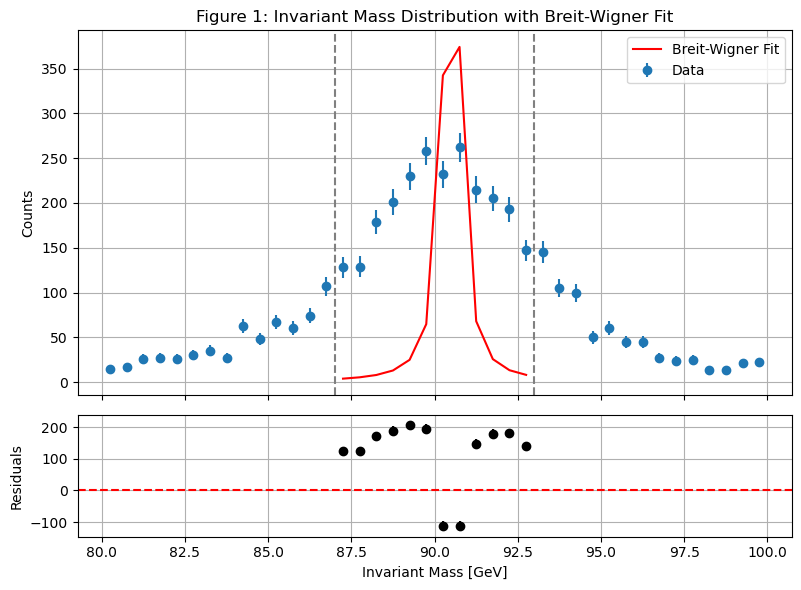

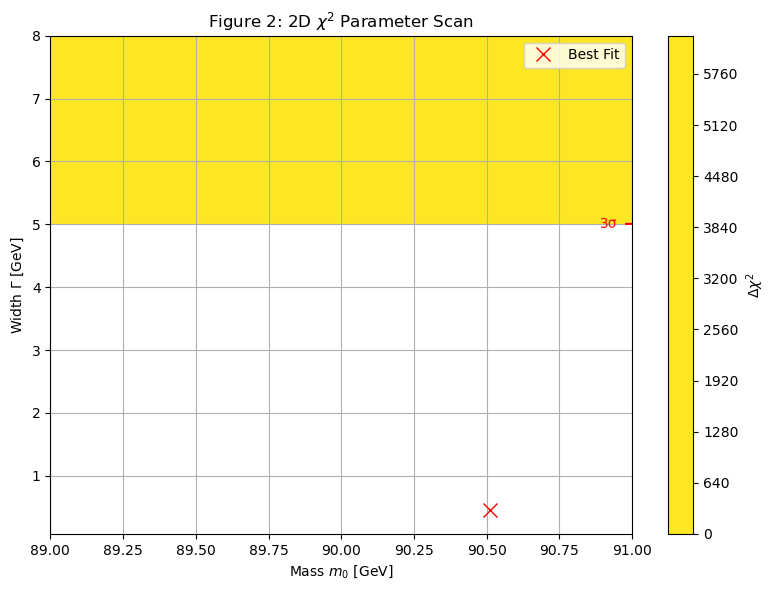

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

# just putting eveyrhting in one cell I think
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("/Users/BR-7274/Desktop/atlas_z_to_ll.csv", header=1)
df.columns = ['pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'E1', 'E2']
df = df.astype(float)
# Compute momentum components
px1 = df["pt1"] * np.cos(df["phi1"])
py1 = df["pt1"] * np.sin(df["phi1"])
pz1 = df["pt1"] * np.sinh(df["eta1"])

px2 = df["pt2"] * np.cos(df["phi2"])
py2 = df["pt2"] * np.sin(df["phi2"])
pz2 = df["pt2"] * np.sinh(df["eta2"])

# Compute total energy and momentum
E_total = df["E1"] + df["E2"]
px_total = px1 + px2
py_total = py1 + py2
pz_total = pz1 + pz2

# Invariant mass calculation
M = np.sqrt(E_total**2 - (px_total**2 + py_total**2 + pz_total**2))

# Histogram
bins = np.linspace(80, 100, 41)
hist, bin_edges = np.histogram(M, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(hist)

# Breit-Wigner function
def breit_wigner(m, m0, gamma):
    return (gamma / 2)**2 / ((m - m0)**2 + (gamma / 2)**2) / np.pi

def normalized_bw(m, m0, gamma):
    return 2500 * breit_wigner(m, m0, gamma)

# Fit range mask
mask = (bin_centers > 87) & (bin_centers < 93)
fit_x = bin_centers[mask]
fit_y = hist[mask]
fit_err = errors[mask]

# Fit the data
popt, pcov = curve_fit(normalized_bw, fit_x, fit_y, p0=[91.0, 2.5], sigma=fit_err, absolute_sigma=True)
m0_fit, gamma_fit = popt
m0_err, gamma_err = np.sqrt(np.diag(pcov))

# Compute fit values and residuals
fit_vals = normalized_bw(fit_x, *popt)
residuals = fit_y - fit_vals

# Chi-square stats
chi_sq = np.sum((residuals / fit_err) ** 2)
ndof = len(fit_x) - len(popt)
p_value = 1 - chi2.cdf(chi_sq, ndof)

# Figure 1: Plot with residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

ax1.errorbar(bin_centers, hist, yerr=errors, fmt='o', label='Data')
ax1.plot(fit_x, fit_vals, label='Breit-Wigner Fit', color='red')
ax1.axvline(87, color='gray', linestyle='--')
ax1.axvline(93, color='gray', linestyle='--')
ax1.set_ylabel("Counts")
ax1.set_title("Figure 1: Invariant Mass Distribution with Breit-Wigner Fit")
ax1.legend()
ax1.grid(True)

ax2.errorbar(fit_x, residuals, yerr=fit_err, fmt='o', color='black')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel("Invariant Mass [GeV]")
ax2.set_ylabel("Residuals")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Part 3: 2D chi-square scan
m_vals = np.linspace(89, 91, 300)
g_vals = np.linspace(5, 8, 300)
M_grid, G_grid = np.meshgrid(m_vals, g_vals)
chi2_grid = np.zeros_like(M_grid)

for i in range(M_grid.shape[0]):
    for j in range(M_grid.shape[1]):
        model = normalized_bw(fit_x, M_grid[i, j], G_grid[i, j])
        chi2_grid[i, j] = np.sum(((fit_y - model) / fit_err) ** 2)

delta_chi2 = chi2_grid - np.min(chi2_grid)

# Figure 2: 2D contour plot
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(M_grid, G_grid, delta_chi2, levels=100, cmap='viridis', vmin=0, vmax=35)
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label(r"$\Delta\chi^2$")

contours = ax.contour(M_grid, G_grid, delta_chi2, levels=[2.30, 11.83], colors=['white', 'red'], linestyles=['solid', 'dashed'])
ax.clabel(contours, inline=True, fontsize=10, fmt={2.30: '1σ', 11.83: '3σ'})

ax.plot(m0_fit, gamma_fit, 'rx', markersize=10, label='Best Fit')
ax.set_xlabel("Mass $m_0$ [GeV]")
ax.set_ylabel("Width $\\Gamma$ [GeV]")
ax.set_title("Figure 2: 2D $\chi^2$ Parameter Scan")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
